In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers import Dropout


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Define paths to your train, test, and validation data
train_data_dir = "/content/gdrive/MyDrive/data/train"
test_data_dir = "/content/gdrive/MyDrive/data/test"
val_data_dir = "/content/gdrive/MyDrive/data/val"

# Use ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',  # Use 'binary' for two classes: 'fake' and 'real'
    classes=['fake', 'real']  # Specify the class labels
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    classes=['fake', 'real']
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    classes=['fake', 'real']
)


Found 11553 images belonging to 2 classes.
Found 3127 images belonging to 2 classes.
Found 1257 images belonging to 2 classes.


In [10]:


# Load pre-trained MobileNetV2 model without top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Add your custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout layer with dropout rate of 0.5
predictions = Dense(1, activation='sigmoid')(x)



# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 1s 0us/step


In [11]:

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Implement early stopping to monitor validation loss and stop training when it stops decreasing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define a learning rate schedule to gradually reduce the learning rate during training
def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 5:
        lr *= 0.1
    return lr

train_steps_per_epoch = 50  # Process 50 batches per epoch for training
val_steps_per_epoch = 20    # Process 20 batches per epoch for validation

# Modify model training to include both early stopping and learning rate scheduling and store the training history
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping, LearningRateScheduler(lr_schedule)]
)

<ipython-input-11-bb590ccc2876>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
50/50 [==============================] - 770s 15s/step - loss: 0.7608 - accuracy: 0.5322 - val_loss: 0.5662 - val_accuracy: 0.7406 - lr: 1.0000e-04
Epoch 2/50
50/50 [==============================] - 522s 11s/step - loss: 0.6865 - accuracy: 0.6056 - val_loss: 0.4903 - val_accuracy: 0.7828 - lr: 1.0000e-04
Epoch 3/50
50/50 [==============================] - 381s 8s/step - loss: 0.6011 - accuracy: 0.6631 - val_loss: 0.4117 - val_accuracy: 0.8781 - lr: 1.0000e-04
Epoch 4/50
50/50 [==============================] - 302s 6s/step - loss: 0.5553 - accuracy: 0.7006 - val_loss: 0.3948 - val_accuracy: 0.8938 - lr: 1.0000e-04
Epoch 5/50
50/50 [==============================] - 253s 5s/step - loss: 0.4880 - accuracy: 0.7469 - val_loss: 0.3664 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 6/50
50/50 [==============================] - 198s 4s/step - loss: 0.4322 - accuracy: 0.7903 - val_loss: 0.3284 - val_accuracy: 0.9234 - lr: 1.0000e-04
Epoch 7/50
50/50 [==============================] 

In [12]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=50)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


<ipython-input-12-05b2c1c47b18>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=50)


Test Accuracy: 88.88%


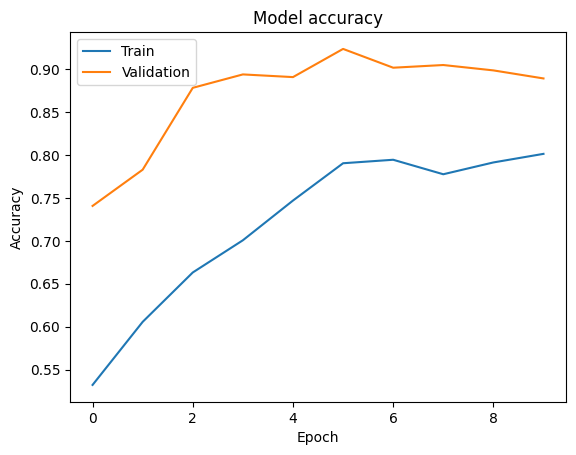

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('/content/gdrive/MyDrive/models_deep_learning/model3/model3_accuracy.png')  # Save as PNG file


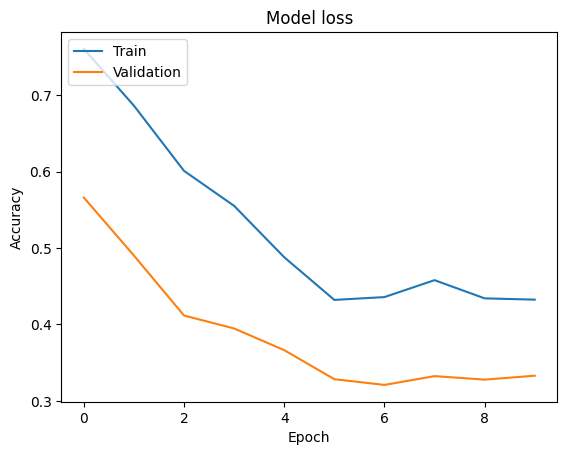

<Figure size 640x480 with 0 Axes>

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('/content/gdrive/MyDrive/models_deep_learning/model3/model3_loss.png')  # Save as PNG file

In [14]:
import pickle

model.save('/content/gdrive/MyDrive/models_deep_learning/model3/model3.h5')

# Save the training history using pickle
with open('/content/gdrive/MyDrive/models_deep_learning/model3/model3_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)



# Your evaluation results
evaluation_results = {
    'accuracy': test_accuracy,
    'loss': test_loss}

# Save evaluation results using pickle
with open('/content/gdrive/MyDrive/models_deep_learning/model3/evaluation_model3_results.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
